<a href="https://colab.research.google.com/github/visiont3lab/machine_learning/blob/master/11-ClassificationProject/ImageProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


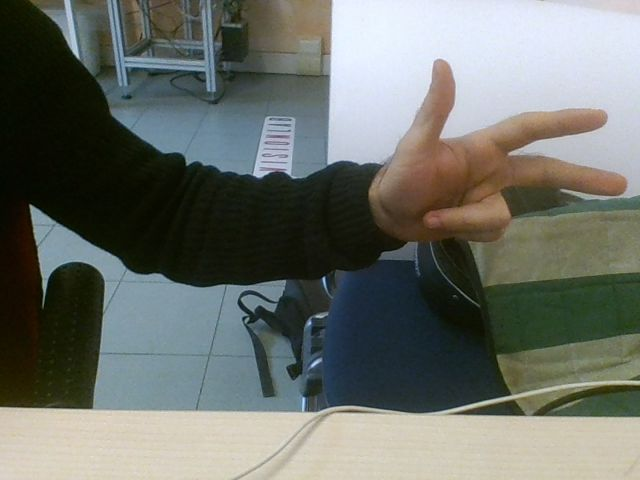

In [51]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [0]:
import numpy as np
import cv2

In [0]:
def kmeans_filter(img):
    # convert to np.float32
    Z = img.reshape((-1,3))
    # convert to np.float32
    Z = np.float32(Z)
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 2 # number of clusters
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))
    return res2


In [0]:
def hsv_filter(frame):
    # hasv color space
    frame = cv2.GaussianBlur(frame,(5,5),30) 
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    # define range of blue color in HSV
    lower_skin = np.array([0,18,36], dtype=np.uint8)
    upper_skin = np.array([25,229,243], dtype=np.uint8)
    # Threshold the HSV image to get only blue colors
    mask = cv2.inRange(hsv, lower_skin, upper_skin)
    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(frame,frame, mask= mask)
 
    # Contour extraction
    contours,hierarchy= cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    mask_fin = np.zeros(mask.shape, np.uint8)
    if len(contours)!=0:
        cnt = max(contours, key = lambda x: cv2.contourArea(x))
       
        # Draw contour and hull       
        hull = cv2.convexHull(cnt)
        cv2.drawContours(res, [cnt], 0, (0, 255, 0), 2)
        cv2.drawContours(res, [hull], 0, (0, 0, 255), 3)
        cv2.drawContours(mask_fin, [cnt], -1, (255),cv2.FILLED)

    return res, mask_fin


In [0]:
def genererate_mask(frame):
    '''
    1. Convert Gray Image
    2. Threshold to only have interested color
    3. Find largest contour
    4. Generate the mask
    5. Save the obtained mask
    '''

    # Flip image
    #frame = cv2.flip(frame,1)

    #print("Original Image Shape: ", frame.shape)

    # Generate region of interest
    roi=frame[50:320,415:630]
    cv2.rectangle(frame,(415,50),(630,320),(0,255,0),0)

    # Create gray image
    #im = roi # cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)

    # get current positions of four trackbars
    #im = kmeans_filter(roi)
    im, mask = hsv_filter(roi)

    return mask, frame, im



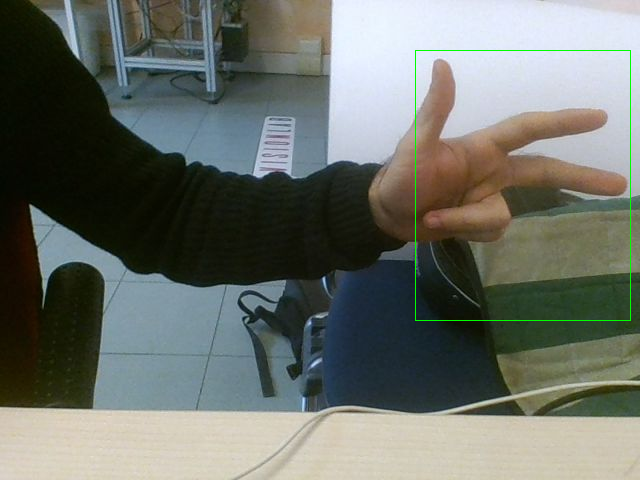

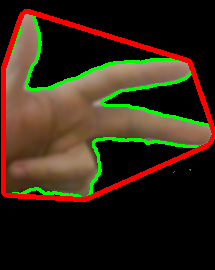

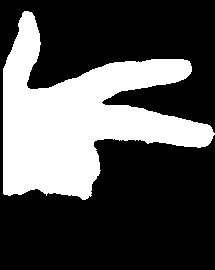

True

In [56]:
# Our algorithm
frame = cv2.imread(filename, 1) 
mask, frame,im = genererate_mask(frame)
cv2_imshow(frame)
cv2_imshow(im)
cv2_imshow(mask)
cv2.imwrite("sign_1.png", mask)  